In [15]:
import numpy as np
import re
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
#from imdb import IMDb
from requests import get
import unicodedata
from bs4 import BeautifulSoup
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

# Reading in the data

In [16]:
df = pd.read_csv('movie_metadata.csv')

In [17]:
df.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000.0
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0.0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000.0
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000.0
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0.0


In [18]:
df.shape

(5043, 28)

In [19]:
df.describe()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,4927.000000,4959.000000,4872.000000,4953.000000,4968.000000,4.104000e+03,4.974000e+03,4974.000000,4961.000000,4956.000000,4.494000e+03,4869.000000,4963.000000,4974.000000,4654.000000,4974.000000
mean,140.572965,107.193991,691.233990,647.790430,6573.525765,4.862765e+07,8.382561e+04,9729.287495,1.372707,273.584746,3.998652e+07,2002.487985,1660.086641,6.439767,2.223350,7572.120828
std,121.858265,24.977939,2822.022077,1672.724849,15077.147622,6.853339e+07,1.386775e+05,18228.145064,2.017257,378.750005,2.073754e+08,12.433410,4055.957071,1.124002,1.393249,19422.681479
min,1.000000,7.000000,0.000000,0.000000,0.000000,1.620000e+02,5.000000e+00,0.000000,0.000000,1.000000,2.180000e+02,1916.000000,0.000000,1.600000,1.180000,0.000000
25%,50.000000,93.000000,7.000000,135.000000,617.000000,5.480826e+06,8.688250e+03,1430.250000,0.000000,65.000000,6.000000e+06,1999.000000,284.000000,5.800000,1.850000,0.000000
50%,110.000000,103.000000,49.000000,372.000000,989.000000,2.559138e+07,3.450400e+04,3097.500000,1.000000,157.000000,2.000000e+07,2005.000000,595.000000,6.600000,2.350000,165.500000
75%,195.000000,118.000000,197.000000,636.000000,11000.000000,6.241428e+07,9.646275e+04,13808.750000,2.000000,327.000000,4.500000e+07,2011.000000,919.000000,7.200000,2.350000,3000.000000
max,813.000000,511.000000,23000.000000,23000.000000,640000.000000,7.605058e+08,1.689764e+06,656730.000000,43.000000,5060.000000,1.221550e+10,2016.000000,137000.000000,9.500000,16.000000,349000.000000


# Filling NAN's with median.

In [20]:
def fill_nan(col):
    df[col] = df[col].fillna(df[col].median())
cols = list(df.columns)
fill_nan(cols)

# Cleaning

In [21]:
def clean_backward_title(col):
    string = col.rstrip()[:-2]
    ''.join((c for c in unicodedata.normalize('NFD', string) if unicodedata.category(c) != 'Mn'))

In [22]:
df['movie_title'] = df['movie_title'].astype(str)

In [23]:
df['movie_title'] = df['movie_title'].apply(clean_backward_title)

In [24]:
s = set()
for i in df['genres']:
    for j in i.split('|'):
        s.add(j)
print s

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-24-3abf3b41413f>, line 5)

In [ ]:
df[list(s)] = 0

# IMDB Revenue scraping script. Redundant right now.. but can be useful in other projects

In [ ]:
# def revenue_parse(url, revenue_per_movie):
#     url = url + 'business'
#     response = get(url)
#     html_soup = BeautifulSoup(response.text, 'html.parser')
#     movie_containers = html_soup.find('div', {"id": "tn15content"})
#     text_spend = movie_containers.text.split('\n')
#     if 'Gross' in text_spend:
#         gross_index = text_spend.index('Gross')
#         rev = [int(i[1:].replace(',', '')) if i[1:].replace(',', '').isdigit() else -1 for i in re.findall(r'[$]\S*', text_spend[gross_index+1])]
#         if len(rev) == 0:
#             revenue_per_movie.append(-1)
#         else:
#             revenue_per_movie.append(max(rev))
#     else:
#         revenue_per_movie.append(-1)


# revenue_per_movie = []

# for i in df['url']:
#     revenue_parse(i, revenue_per_movie)

# Describing the data to find the Missing values

In [ ]:
df.describe()

# Normalizing or Standardizing the data.. change the commenting as per your needs

In [ ]:
col = list(df.describe().columns)

In [ ]:
sc = StandardScaler()
# sc = MinMaxScaler()
temp = sc.fit_transform(df[col])
df[col] = temp
df.head()

In [27]:
df_standard = df[list(df.describe().columns)]
df_standard.columns

Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
       'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'num_user_for_reviews', 'budget', 'title_year',
       'actor_2_facebook_likes', 'imdb_score', 'aspect_ratio',
       'movie_facebook_likes'],
      dtype='object')

# PCA

In [28]:
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df_standard)

In [29]:
df_pca

array([[  2.27373848e+08,   7.07724533e+08,  -2.13614069e+05],
       [  2.72473255e+08,   2.54482985e+08,   1.04441952e+04],
       [  2.13189864e+08,   1.47414977e+08,  -2.44946677e+04],
       ..., 
       [ -3.85215660e+07,  -1.72361571e+07,  -5.69043895e+04],
       [ -1.95509321e+07,  -4.35884199e+07,  -1.95016231e+04],
       [ -3.95312076e+07,  -4.27222881e+07,  -1.65127805e+04]])

In [30]:
pca.explained_variance_ratio_

array([  9.08941658e-01,   9.10580558e-02,   2.66958440e-07])

In [31]:
df_standard['pca_one'] = df_pca[:, 0]
df_standard['pca_two'] = df_pca[:, 1]
df_standard['pca_three'] = df_pca[:, 2]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [33]:
df_standard.shape, df.shape

((5043, 19), (5043, 28))

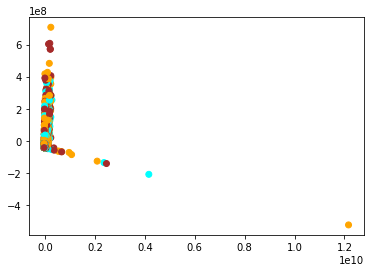

In [34]:
plt.scatter(df_standard['pca_one'], df_standard['pca_two'], 
            color=['orange', 'cyan', 'brown'], cmap='viridis')
# for m, p1, p2 in zip(df['movie_title'], df_standard['pca_one'], df_standard['pca_two']):
#     print m
#     plt.text(p1, p2, s=m, 
#              color=np.random.rand(3)*0.7)